In [1]:
import os
import pandas as pd
import yaml
SOL_ROOT = '/home/ddon0001/PhD/experiments/scaled/no_div_constraint'
SCALES_PATH = '/home/ddon0001/PhD/data/cell_tracking_challenge/scales.yaml'

ds_summary = pd.read_csv(f'{SOL_ROOT}/summary.csv')
with open(SCALES_PATH, 'r') as f:
    scales = yaml.safe_load(f)

all_info_df = pd.read_csv(os.path.join(SOL_ROOT, 'all_node_info.csv'))

In [2]:
all_divisions = all_info_df[all_info_df.is_parent]
all_divisions.columns

Index(['ds_name', 'node_id', 'node_area', 'component_id', 'comp_merge',
       'comp_div', 'comp_correct', 'is_parent', 'is_superparent',
       'is_merge_vertex', 'child_distance_difference', 'child_distance_sum',
       'interchild_distance', 'div_angle', 'child_area_sum', 'div_correct',
       'div_valid', 'first_chosen_neighbour_rank',
       'second_chosen_neighbour_rank', 'first_child_distance',
       'first_child_area', 'second_child_distance', 'second_child_area',
       'div_cost', 'mig_correct', 'child_area_prop',
       'neighbour_rank_difference', 'neighbour_rank_sum'],
      dtype='object')

In [3]:
columns_of_interest = [
    'node_area',
    'child_distance_difference',
    'child_distance_sum',
    'interchild_distance',
    'div_angle',
    'div_valid',
    'neighbour_rank_sum',
    'neighbour_rank_difference',
    'child_area_prop',
    'div_correct'
]

## RandomForest Classifier

Is a simple classifier able to use these features to predict whether a given division is correct or incorrect? If so, then these features may be sufficiently discriminating to use in an unsupervised way for initializing and 'training' the tracking model.

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

all_divisions = all_info_df[all_info_df.is_parent]

ds_names = []
accuracies = []
n_div = []
n_train = []
n_test = []
best_models = {}
searches = {}
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    data_df = all_divisions[all_divisions.ds_name == ds_name][columns_of_interest]
    if len(data_df) < 15:
        continue
    X = data_df.drop(columns=['div_correct'])
    y = data_df.div_correct
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    rf = RandomForestClassifier()
    param_dist = {
        # number of trees
        'n_estimators': randint(2,100),
        # depth of the tree
        'max_depth': randint(2,30)
    }

    # searching for best hyperparameters using randomized search
    search = RandomizedSearchCV(
        rf,
        param_distributions = param_dist,
        n_iter = 60,
        cv = 5
    )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    best_models[ds_name] = best_model
    searches[ds_name] = search
    
    ds_names.append(ds_name)
    accuracies.append(accuracy)
    n_div.append(len(data_df))
    n_train.append(len(X_train))
    n_test.append(len(X_test))
classifier_df = pd.DataFrame({
    'ds_name': ds_names,
    'accuracy': accuracies,
    'n_div': n_div,
    'n_train': n_train,
    'n_test': n_test
})
print(classifier_df)


             ds_name  accuracy  n_div  n_train  n_test
0  Fluo-N2DL-HeLa_01  0.947368     93       74      19
1  Fluo-N2DL-HeLa_02  0.931818    220      176      44
2    BF-C2DL-MuSC_01  1.000000     56       44      12
3    BF-C2DL-MuSC_02  1.000000     69       55      14
4     BF-C2DL-HSC_02  0.906250    160      128      32
5    PhC-C2DL-PSC_01  0.869822    843      674     169
6    PhC-C2DL-PSC_02  0.935484    463      370      93
7    Fluo-N3DH-CE_01  0.955882    336      268      68
8    Fluo-N3DH-CE_02  0.854167    239      191      48
17


What does our hyperparameter search look like?

In [27]:
# check each search for whether we've "converged" on best values
ds_names = []
n_estimators = []
max_depths = []
scores = []
for ds_name, search in searches.items():
    search_results = search.cv_results_
    m_depth = search_results['param_max_depth']
    n_est = search_results['param_n_estimators']
    score = search_results['mean_test_score']

    ds_names.extend([ds_name for _ in range(len(m_depth))])
    n_estimators.extend(n_est)
    max_depths.extend(m_depth)
    scores.extend(score)
search_df = pd.DataFrame({
    'ds_name': ds_names,
    'n_trees': n_estimators,
    'max_depth': max_depths,
    'score': scores
})

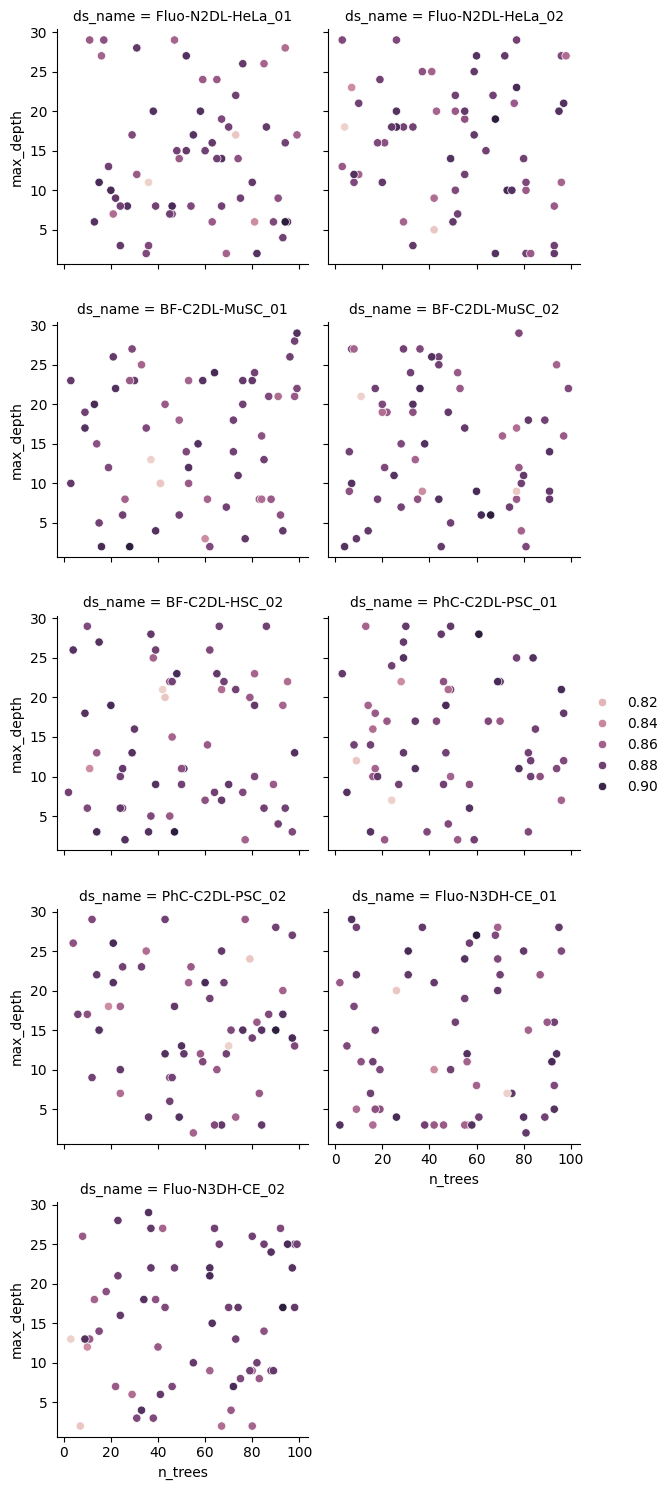

In [28]:
import seaborn as sns

grid = sns.FacetGrid(search_df, col='ds_name', col_wrap=2, sharex=True, sharey=True, legend_out=True)
grid.map_dataframe(sns.scatterplot, x='n_trees', y='max_depth', hue=score)
grid.add_legend()

Cross validation checking best estimator on the entire data to make sure test set prediction wasn't a fluke.

In [22]:
from sklearn.model_selection import cross_val_score

ds_names = []
average_score = []
std_dev = []
for ds_name, model in best_models.items():
    data_df = all_divisions[all_divisions.ds_name == ds_name][columns_of_interest]
    X = data_df.drop(columns=['div_correct'])
    y = data_df.div_correct
    scores = cross_val_score(model, X, y, cv=5)
    ds_names.append(ds_name)
    average_score.append(scores.mean())
    std_dev.append(scores.std())
cross_val_df = pd.DataFrame({
    'ds_name': ds_names,
    'average_score': average_score,
    'std_dev': std_dev
})
cross_val_df

,ds_name,average_score,std_dev
0,Fluo-N2DL-HeLa_01,0.870175,0.083374
1,Fluo-N2DL-HeLa_02,0.877273,0.068333
2,BF-C2DL-MuSC_01,0.981818,0.036364
3,BF-C2DL-MuSC_02,1.000000,0.000000
4,BF-C2DL-HSC_02,0.912500,0.036443
5,PhC-C2DL-PSC_01,0.887363,0.026802
6,PhC-C2DL-PSC_02,0.933029,0.025063
7,Fluo-N3DH-CE_01,0.910711,0.009454
8,Fluo-N3DH-CE_02,0.870035,0.037153


In [21]:
ds_names = []
feature_names = []
importances = []
for ds_name, model in best_models.items():
    feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    for feature_name, importance in feature_importances.items():
        ds_names.append(ds_name)
        feature_names.append(feature_name)
        importances.append(importance)
importance_df = pd.DataFrame({
    'ds_name': ds_names,
    'feature_name': feature_names,
    'importance': importances
})

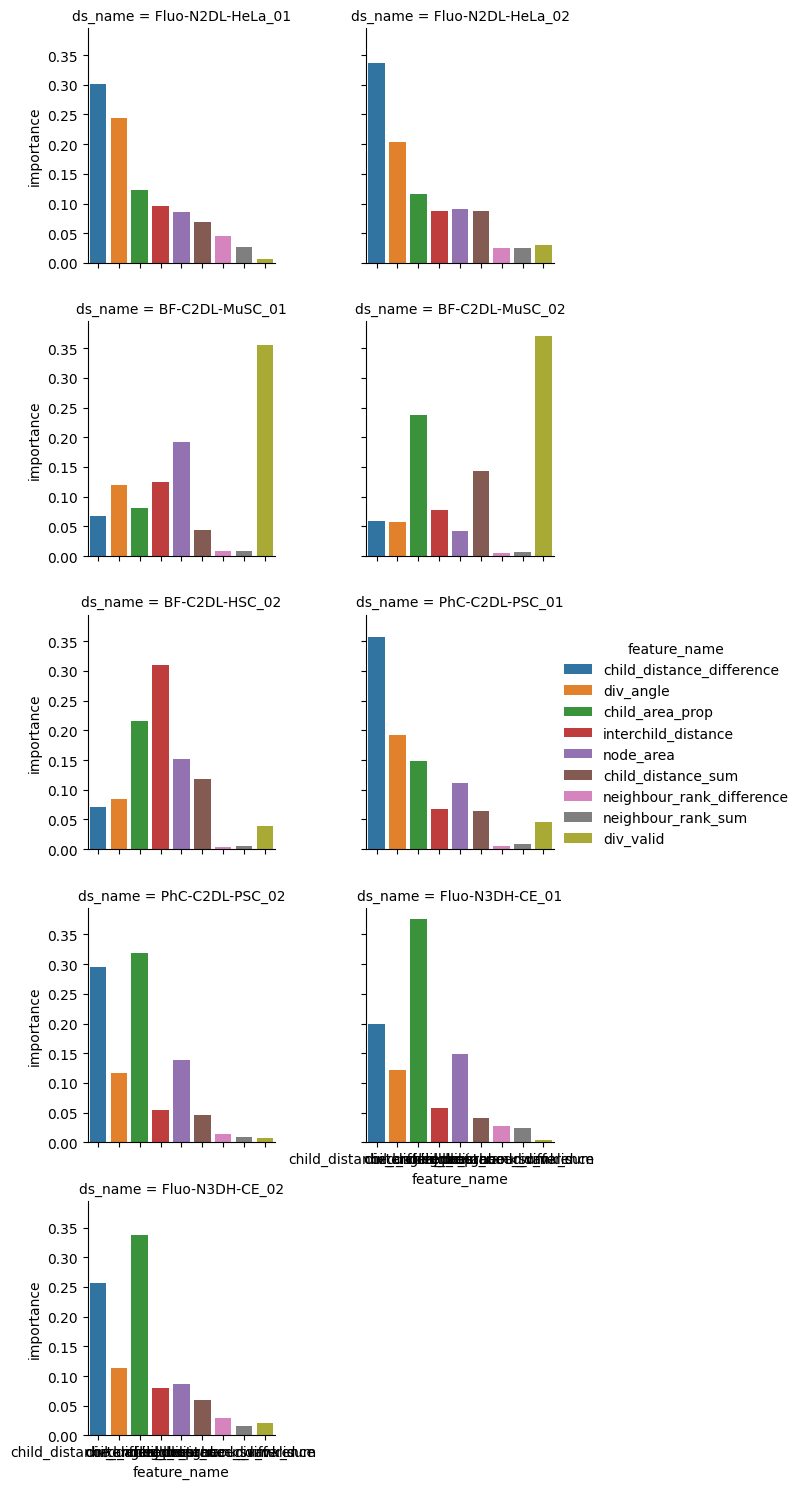

In [22]:
import seaborn as sns

grid = sns.FacetGrid(importance_df, col='ds_name', col_wrap=2, sharex=True, sharey=True, legend_out=True, hue='feature_name')
grid.map_dataframe(sns.barplot, x='feature_name', y='importance')
grid.add_legend()

In [38]:
# look at whether unsupervised clustering can be used to distinguish divisions (kprototypes)
from kmodes.kprototypes import KPrototypes
count_skipped = 0
models = {}
clustered = {}
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    data_df = all_divisions[all_divisions.ds_name == ds_name][columns_of_interest]
    if len(data_df) < 15:
        count_skipped += 1
        continue
    X = data_df.drop(columns=['div_correct'])

    kp_model = KPrototypes(n_clusters=2, init='Cao', verbose=2)
    kp_model.fit(X, categorical=[5])
    cluster = kp_model.predict(X, categorical=[5])
    data_df['cluster'] = cluster

    models[ds_name] = kp_model
    clustered[ds_name] = data_df

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1, ncost: 907824.3608949011
Run: 1, iteration: 2/100, moves: 0, ncost: 907824.3608949011
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 28, ncost: 1063695.7422923408
Run: 2, iteration: 2/100, moves: 15, ncost: 939824.515567908
Run: 2, iteration: 3/100, moves: 7, ncost: 910353.6890470219
Run: 2, iteration: 4/100, moves: 2, ncost: 907824.3608949013
Run: 2, iteration: 5/100, moves: 0, ncost: 907824.3608949013
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 3, ncost: 907824.3608949011
Run: 3, iteration: 2/100, moves: 0, ncost: 907824.3608949011
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 1, ncost: 907824.360

In [39]:
ds_names = []
clusters = []
div_correct = []
for ds_name, data_df in clustered.items():
    ds_names.extend([ds_name for _ in range(len(data_df))])
    clusters.extend(data_df.cluster.values)
    div_correct.extend(data_df.div_correct.values)
all_cluster_df = pd.DataFrame({
    'ds_name': ds_names,
    'cluster': clusters,
    'div_correct': div_correct
})


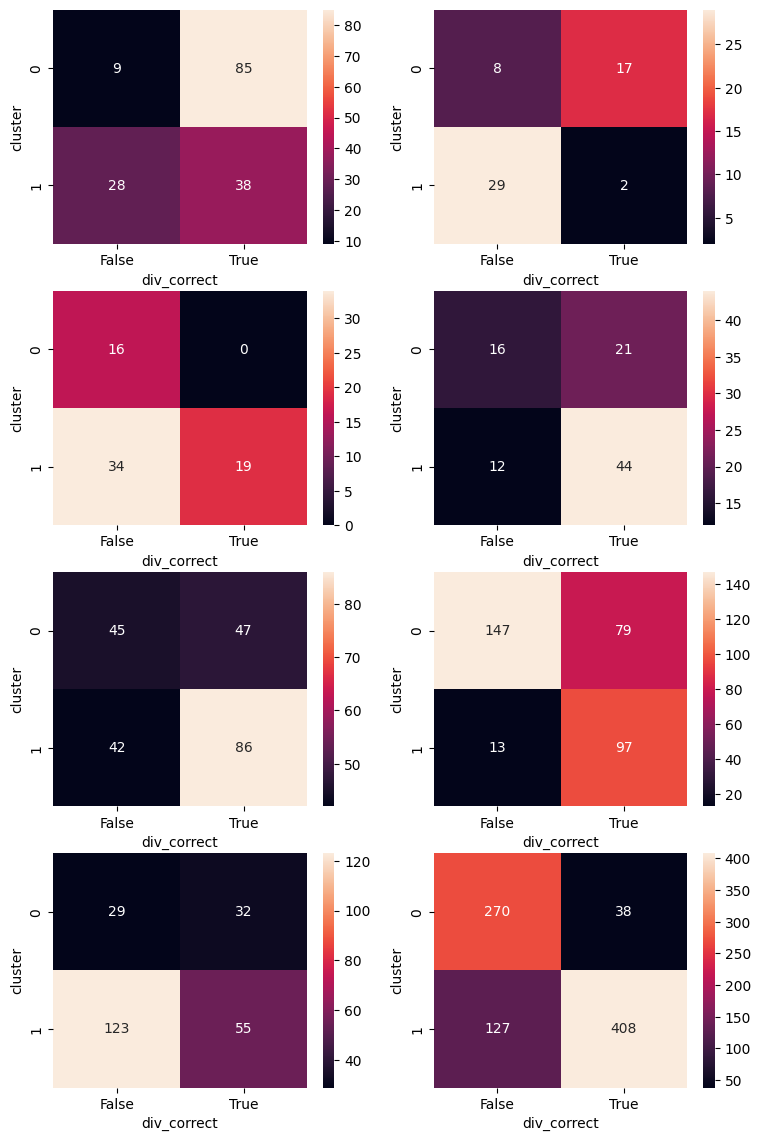

In [40]:
import pandas as pd
import seaborn as sns
from numpy.random import randint
import matplotlib.pyplot as plt

grouped = all_cluster_df.groupby('ds_name')
fig, axs = plt.subplots(figsize=(9,14), nrows=4, ncols=2)

targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    info = grouped.get_group(key)
    cont_table = pd.crosstab(info.cluster, info.div_correct)
    sns.heatmap(cont_table, annot=True, fmt='g', ax=ax); 
plt.show()

In [47]:
from sklearn.cluster import k_means

kmeans_cols = columns_of_interest
count_skipped = 0
clustered = {}
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    data_df = all_divisions[all_divisions.ds_name == ds_name][kmeans_cols]
    if len(data_df) < 15:
        count_skipped += 1
        continue
    X = data_df.drop(columns=['div_correct'])

    centroid, label, inertia = k_means(
        X, n_clusters=2, n_init="auto", random_state=0
    )
    data_df['cluster'] = label

    clustered[ds_name] = data_df

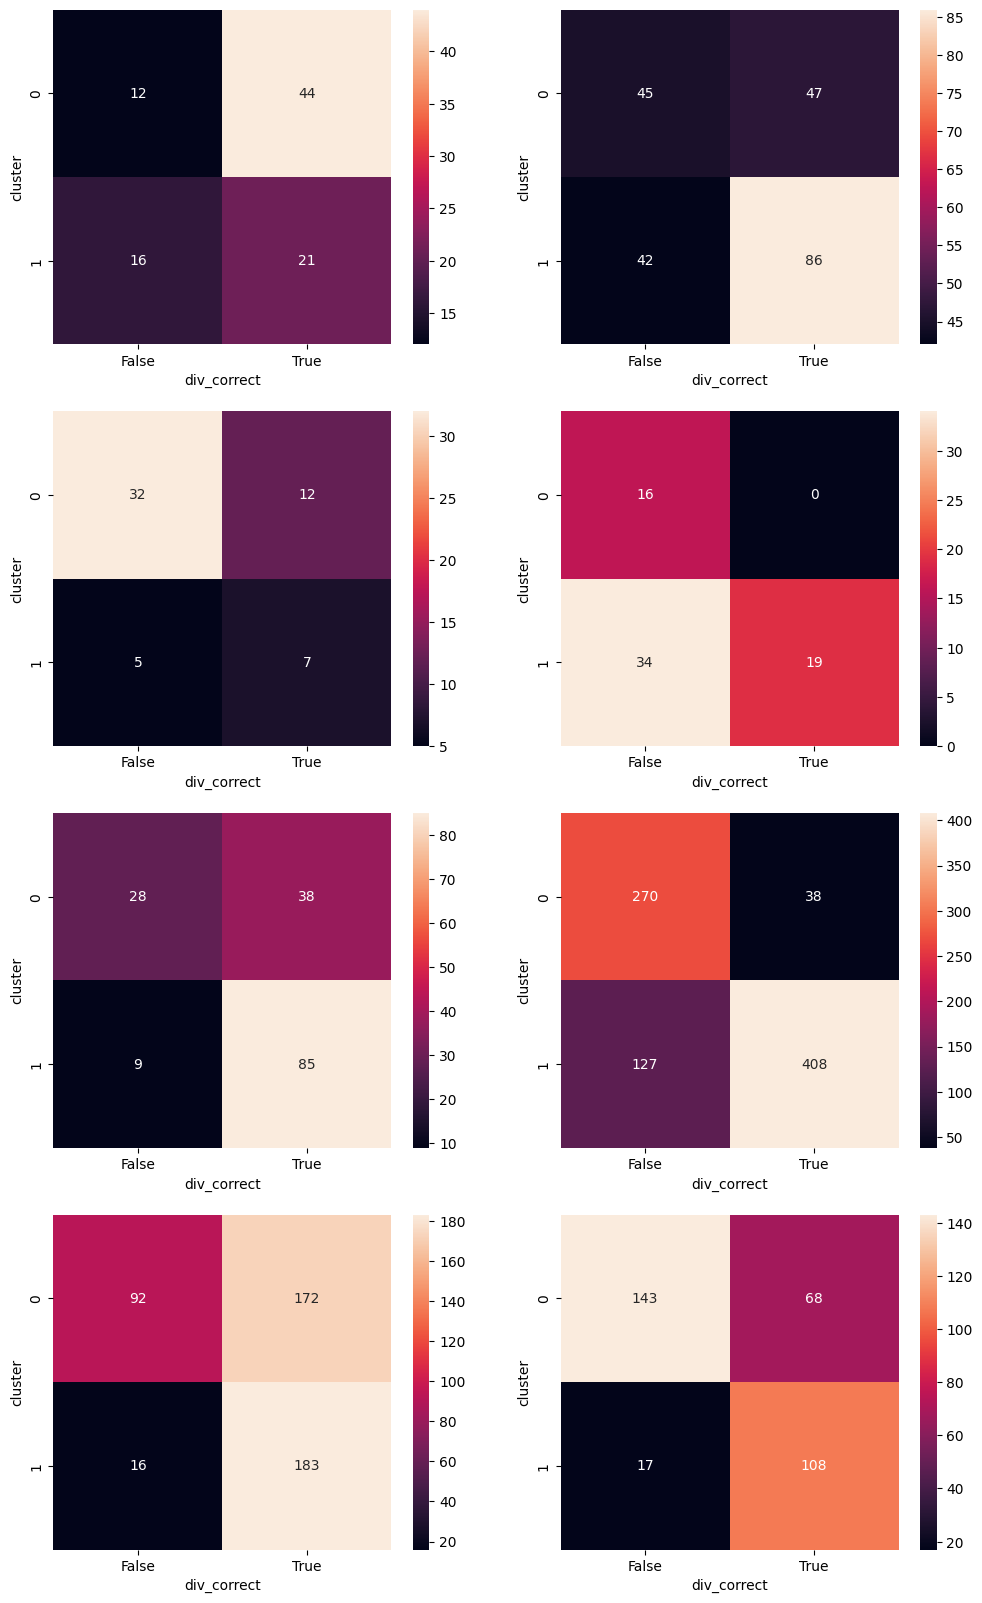

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(12,20), nrows=4, ncols=2)

targets = zip(clustered.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    info = clustered[key]
    cont_table = pd.crosstab(info.cluster, info.div_correct)
    sns.heatmap(cont_table, annot=True, fmt='g', ax=ax); 
plt.show()

In [49]:
from sklearn.cluster import HDBSCAN

hdb_cols = columns_of_interest
hdb_clustered = {}
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    data_df = all_divisions[all_divisions.ds_name == ds_name][hdb_cols]
    if len(data_df) < 15:
        continue
    X = data_df.drop(columns=['div_correct'])

    hdb = HDBSCAN()
    hdb.fit(X)
    data_df['cluster'] = hdb.labels_

    hdb_clustered[ds_name] = data_df

We can't set the number of clusters for HDBSCAN, so not very useful.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(12,20), nrows=4, ncols=2)

targets = zip(hdb_clustered.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    info = hdb_clustered[key]
    cont_table = pd.crosstab(info.cluster, info.div_correct)
    sns.heatmap(cont_table, annot=True, fmt='g', ax=ax); 
plt.show()

Trying kmeans with standardized data, removing binary feature and the neighbour rank features which take on very few values.

In [19]:
from sklearn.cluster import k_means
from sklearn.preprocessing import MinMaxScaler, StandardScaler

kmeans_scaled_cols = [
    'node_area',
    'child_distance_difference',
    'child_distance_sum',
    'interchild_distance',
    'div_angle',
    'child_area_prop',
    'div_correct'
]
count_skipped = 0
scaled_k_means_clustered = {}
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    data_df = all_divisions[all_divisions.ds_name == ds_name][kmeans_scaled_cols]
    if len(data_df) < 15:
        count_skipped += 1
        continue
    X = data_df.drop(columns=['div_correct'])
    X = StandardScaler().fit_transform(X)

    centroid, label, inertia = k_means(
        X, n_clusters=2, n_init="auto", random_state=0
    )
    data_df['cluster'] = label

    scaled_k_means_clustered[ds_name] = data_df

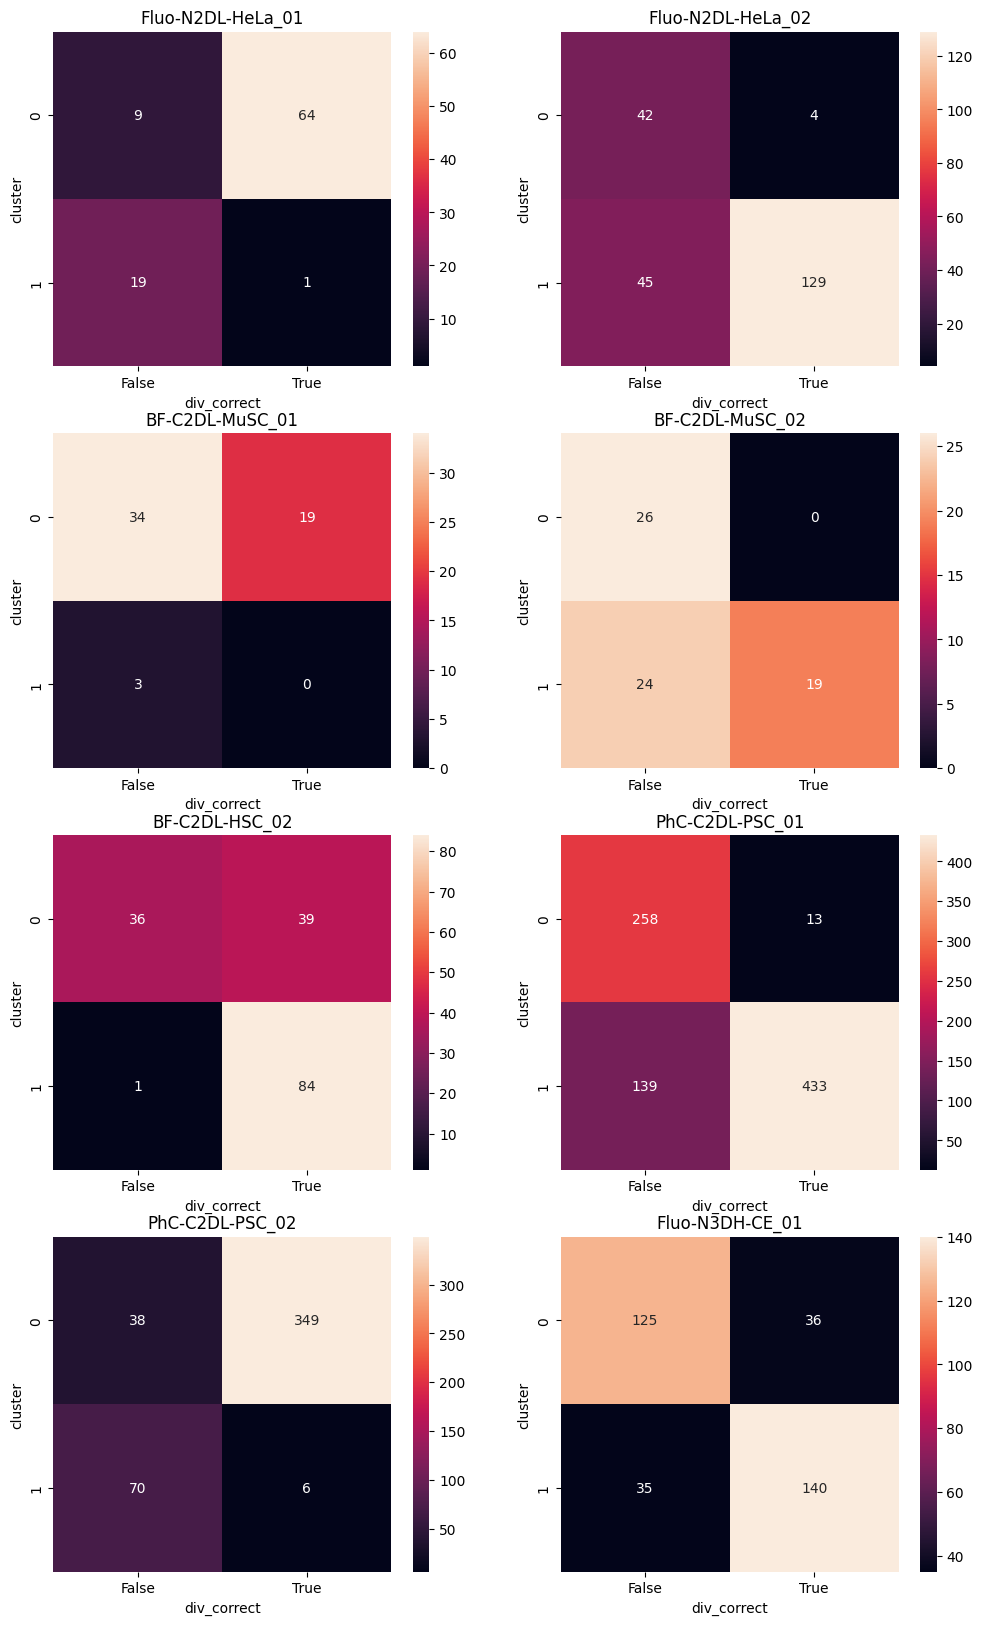

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(12,20), nrows=4, ncols=2)

targets = zip(scaled_k_means_clustered.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    info = scaled_k_means_clustered[key]
    cont_table = pd.crosstab(info.cluster, info.div_correct)
    sns.heatmap(cont_table, annot=True, fmt='g', ax=ax)
    ax.set_title(key)
plt.show()

Looking at whether Gaussian Mixture Model can improve on the K-means centroids.

In [37]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

gmm_scaled_cols = kmeans_scaled_cols
count_skipped = 0
scaled_gmm_clustered = {}
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    data_df = all_divisions[all_divisions.ds_name == ds_name][gmm_scaled_cols]
    if len(data_df) < 15:
        count_skipped += 1
        continue
    X = data_df.drop(columns=['div_correct'])
    X = StandardScaler().fit_transform(X)

    label = GaussianMixture(n_components=2, init_params='kmeans').fit_predict(X)
    data_df['cluster'] = label

    scaled_gmm_clustered[ds_name] = data_df

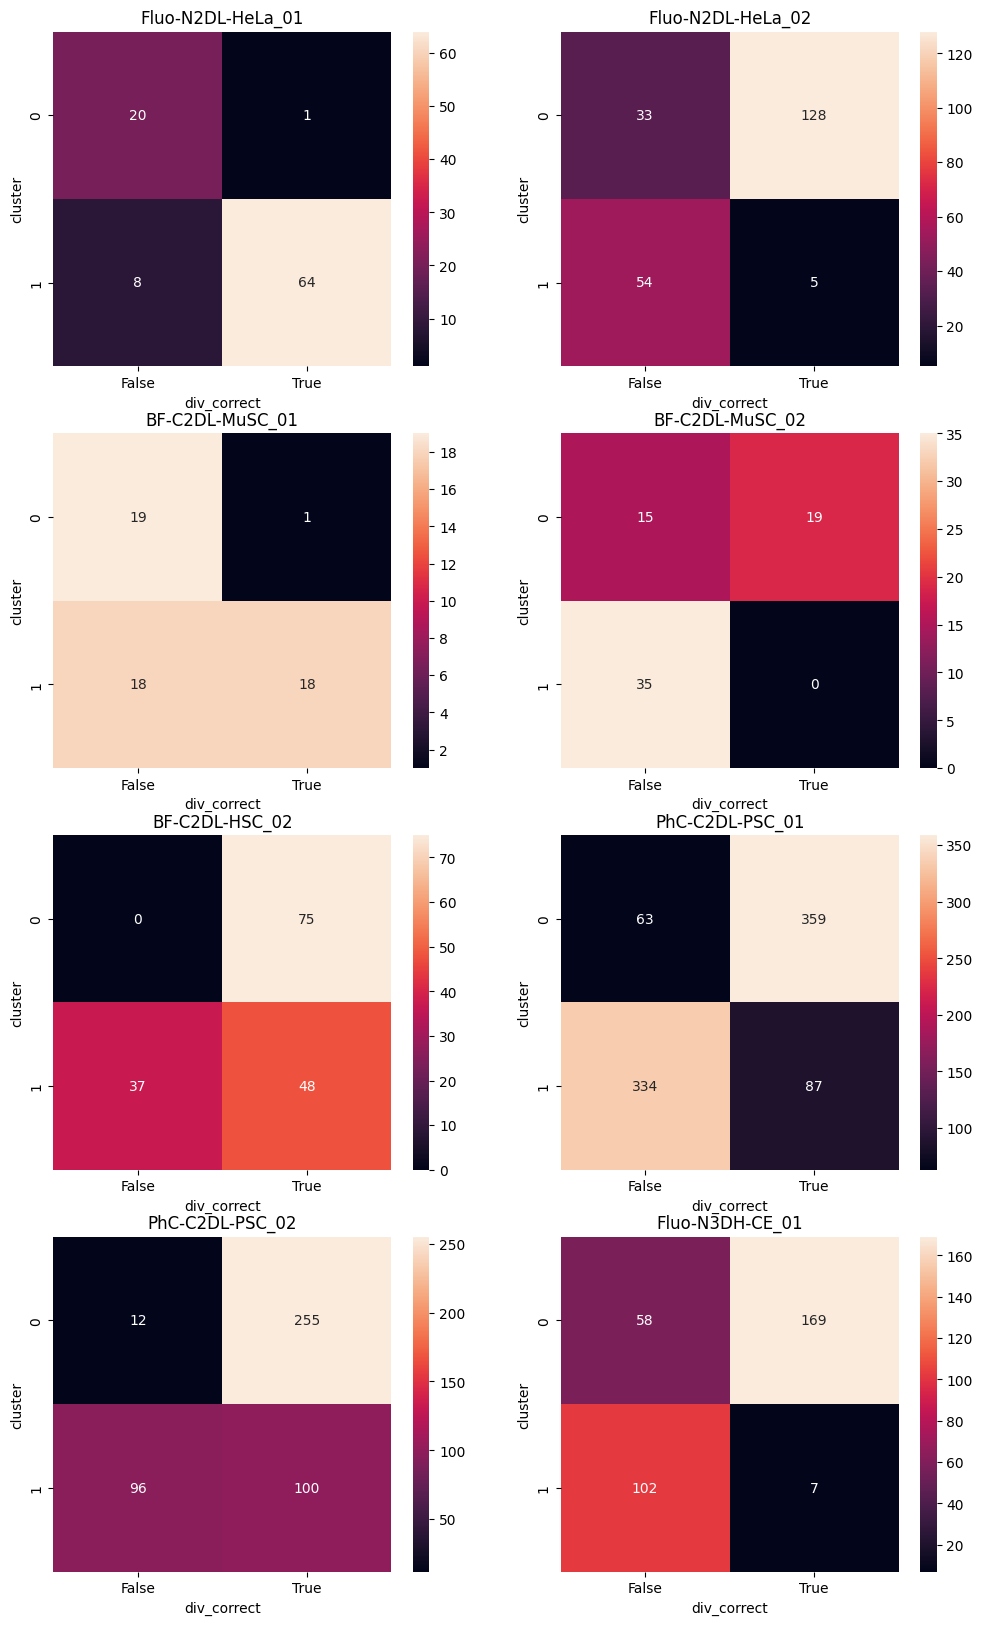

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(12,20), nrows=4, ncols=2)

targets = zip(scaled_gmm_clustered.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    info = scaled_gmm_clustered[key]
    cont_table = pd.crosstab(info.cluster, info.div_correct)
    sns.heatmap(cont_table, annot=True, fmt='g', ax=ax); 
    ax.set_title(key)
plt.show()

Visualizing the PCA and UMAP components of the scaled GMM features used, and keeping prediction probability for cluster assignment.

In [38]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import umap

scaled_gmm_pca_cols = [
    'node_area',
    'child_distance_difference',
    'child_distance_sum',
    'interchild_distance',
    'div_angle',
    'child_area_prop',
    'div_correct'
]
count_skipped = 0
scaled_gmm_pca_clustered = {}
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    data_df = all_divisions[all_divisions.ds_name == ds_name][scaled_gmm_pca_cols]
    if len(data_df) < 15:
        count_skipped += 1
        continue
    X = data_df.drop(columns=['div_correct'])
    X = StandardScaler().fit_transform(X)

    X_pca = PCA(n_components=2).fit_transform(X)
    X_umap = umap.UMAP().fit_transform(X)
    label = GaussianMixture(n_components=2, init_params='kmeans').fit_predict(X)
    proba = GaussianMixture(n_components=2, init_params='kmeans').fit(X).predict_proba(X)

    data_df['cluster'] = label
    data_df[['proba_0', 'proba_1']] = proba
    data_df[['pca_0', 'pca_1']] = X_pca
    data_df[['umap_0', 'umap_1']] = X_umap
    data_df['ds_name'] = ds_name

    scaled_gmm_pca_clustered[ds_name] = data_df

In [39]:
scaled_gmm_pca_df = pd.concat(scaled_gmm_pca_clustered.values())
scaled_gmm_pca_df.head()

,node_area,child_distance_difference,child_distance_sum,interchild_distance,div_angle,child_area_prop,div_correct,cluster,proba_0,proba_1,pca_0,pca_1,umap_0,umap_1,ds_name
6794,516.0,7.427086,25.154909,24.861198,161.646893,1.548450,True,0,0.012868,9.871322e-01,0.816008,-0.351845,9.132642,4.243124,Fluo-N2DL-HeLa_01
7145,472.0,5.755339,20.365291,20.150061,162.611362,0.601695,True,0,1.000000,1.800532e-13,-0.679743,0.568714,8.990582,0.807806,Fluo-N2DL-HeLa_01
7184,243.0,2.041230,29.224318,28.851576,161.633222,2.893004,True,0,0.000905,9.990948e-01,1.887397,-3.239840,10.163533,6.117830,Fluo-N2DL-HeLa_01
7238,294.0,2.957245,19.383616,19.304686,169.532404,2.319728,True,0,0.015491,9.845092e-01,-0.391529,-1.939804,11.776123,5.261423,Fluo-N2DL-HeLa_01
7371,373.0,14.095593,26.013511,24.833986,138.509332,1.745308,True,0,0.000224,9.997760e-01,1.584489,-0.623155,8.289973,4.454544,Fluo-N2DL-HeLa_01


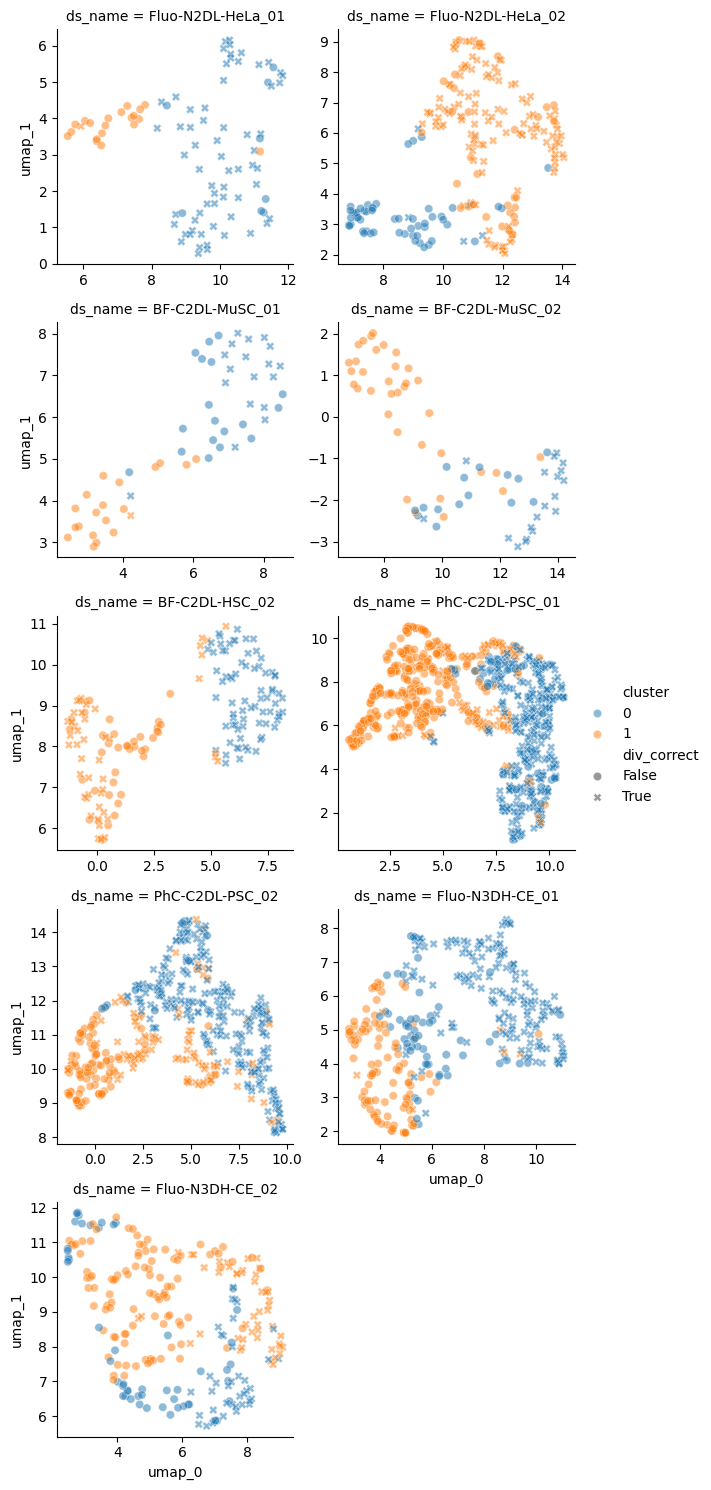

In [40]:
import seaborn as sns

only_certainties = scaled_gmm_pca_df[(scaled_gmm_pca_df.proba_0 == 1)]
grid = sns.FacetGrid(scaled_gmm_pca_df, col='ds_name', col_wrap=2, sharex=False, sharey=False, legend_out=True)
grid.map_dataframe(sns.scatterplot, x='umap_0', y='umap_1', hue='cluster', style='div_correct', alpha=0.5)
grid.add_legend()

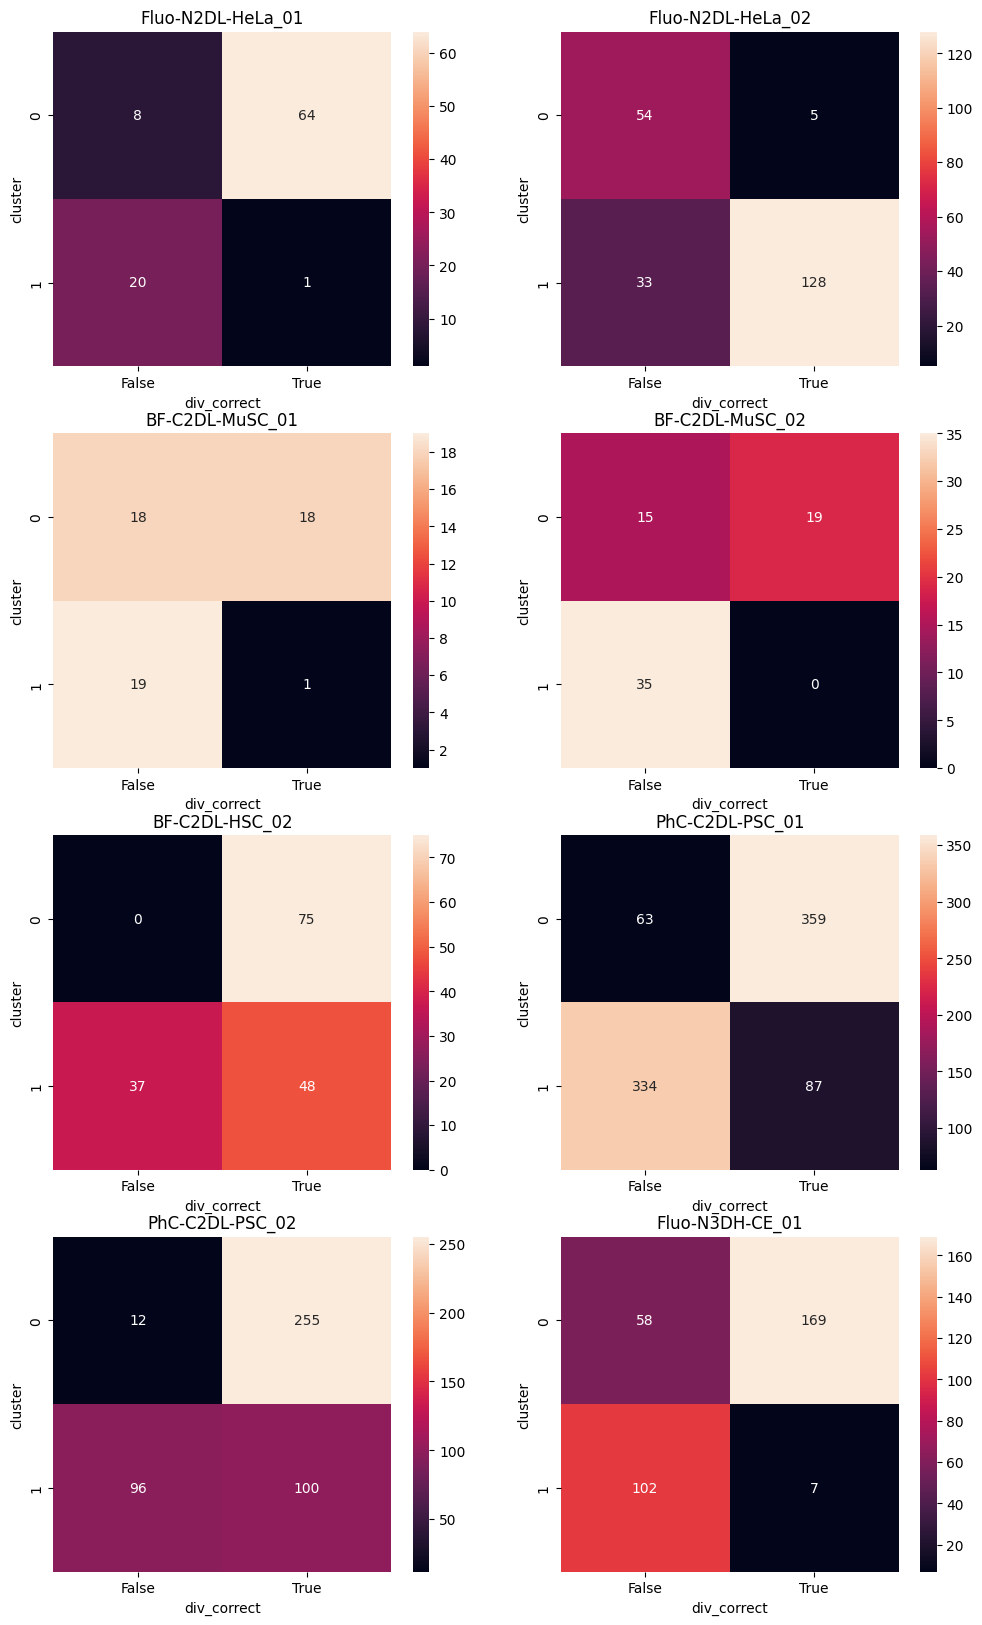

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(12,20), nrows=4, ncols=2)

targets = zip(scaled_gmm_pca_clustered.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    info = scaled_gmm_pca_clustered[key]
    cont_table = pd.crosstab(info.cluster, info.div_correct)
    sns.heatmap(cont_table, annot=True, fmt='g', ax=ax); 
    ax.set_title(key)
plt.show()